In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import seaborn as sns
import os
# Any results you write to the current directory are saved as output.

D:\Apps\ana\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import BatchNormalization, Dropout
from keras.initializers import HeNormal

In [3]:
df=pd.read_csv("train.csv")
df.head()

,left,right
0,aaa,osr
1,aaz,mqw
2,abh,cdx
3,abn,uzp
4,abq,bbd


In [4]:
print("Number of samples: ",len(df))

Number of samples:  2000


In [5]:
# sns.distplot(df.has_cactus)

In [6]:
from PIL import Image
from skimage.transform import resize
import random

In [7]:
import os

# 指定你想要列出文件的目录路径
directory_path = 'train/right'

# 使用os.listdir()获取目录中的所有文件和子目录名
all_items = os.listdir(directory_path)

# 过滤出只是文件的名字，不包括子目录
file_names = [item for item in all_items if os.path.isfile(os.path.join(directory_path, item))]

print(len(file_names))

2000


In [8]:
train_data = []
for i in range(2000):
    temp = []
    right_list = []
    left_path = df.left[i] + '.jpg'
    right_path = df.right[i] +'.jpg'
    temp.append(left_path)
    temp.append(right_path)
    right_list.append(right_path)
    temp.append(0)
    train_data.append(temp)
    for j in range(4):
        temp = []
        while True:
            right_path = df.right[random.randrange(2000)] +'.jpg'
            if right_path not in right_list:
                temp.append(left_path)
                temp.append(right_path)
                right_list.append(right_path)
                temp.append(1)
                train_data.append(temp)
                break

In [9]:
len(train_data)

40000

In [10]:
train_data[:50]

[['aaa.jpg', 'osr.jpg', 0],
 ['aaa.jpg', 'glf.jpg', 1],
 ['aaa.jpg', 'zhk.jpg', 1],
 ['aaa.jpg', 'bak.jpg', 1],
 ['aaa.jpg', 'bkp.jpg', 1],
 ['aaa.jpg', 'vmi.jpg', 1],
 ['aaa.jpg', 'erp.jpg', 1],
 ['aaa.jpg', 'jck.jpg', 1],
 ['aaa.jpg', 'nut.jpg', 1],
 ['aaa.jpg', 'rai.jpg', 1],
 ['aaa.jpg', 'zlf.jpg', 1],
 ['aaa.jpg', 'mrv.jpg', 1],
 ['aaa.jpg', 'xzz.jpg', 1],
 ['aaa.jpg', 'nvo.jpg', 1],
 ['aaa.jpg', 'xws.jpg', 1],
 ['aaa.jpg', 'muz.jpg', 1],
 ['aaa.jpg', 'wdv.jpg', 1],
 ['aaa.jpg', 'zls.jpg', 1],
 ['aaa.jpg', 'uzp.jpg', 1],
 ['aaa.jpg', 'tis.jpg', 1],
 ['aaz.jpg', 'mqw.jpg', 0],
 ['aaz.jpg', 'dim.jpg', 1],
 ['aaz.jpg', 'ocn.jpg', 1],
 ['aaz.jpg', 'iur.jpg', 1],
 ['aaz.jpg', 'sos.jpg', 1],
 ['aaz.jpg', 'zdw.jpg', 1],
 ['aaz.jpg', 'rcr.jpg', 1],
 ['aaz.jpg', 'wba.jpg', 1],
 ['aaz.jpg', 'psa.jpg', 1],
 ['aaz.jpg', 'uds.jpg', 1],
 ['aaz.jpg', 'kkt.jpg', 1],
 ['aaz.jpg', 'odn.jpg', 1],
 ['aaz.jpg', 'vos.jpg', 1],
 ['aaz.jpg', 'nhy.jpg', 1],
 ['aaz.jpg', 'dvz.jpg', 1],
 ['aaz.jpg', 'abv.jp

In [11]:
class ProjectDataGenerator(Sequence):
    def __init__(self, root_path, data_list, datagen, target_size=(80,98), batch_size=32, shuffle=True):
        self.root_path = root_path
        self.data_list = data_list
        self.datagen = datagen
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data_list))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.data_list) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = [self.data_list[i] for i in batch_indices]
        
        batch_images_1 = []
        batch_images_2 = []
        batch_labels = []

        for data in batch_data:
            img1_path, img2_path, label = data
            img1 = image.load_img(self.root_path+'/left/'+img1_path, target_size=self.target_size, color_mode = "grayscale")
            img2 = image.load_img(self.root_path+'/right/'+img2_path, target_size=self.target_size, color_mode = "grayscale")

            x1 = image.img_to_array(img1)
            x2 = image.img_to_array(img2)

            # Apply data augmentation
            x1 = self.datagen.random_transform(x1)
            x2 = self.datagen.random_transform(x2)

            batch_images_1.append(x1)
            batch_images_2.append(x2)
            batch_labels.append(label)

        return [np.array(batch_images_1), np.array(batch_images_2)], np.array(batch_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # rotation_range=40,        # Randomly rotate images in the range (degrees, 0 to 180)
    # width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
    # height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
    # shear_range=0.2,         # Randomly apply shearing transformations
    # zoom_range=0.2,          # Randomly zoom inside pictures
    # horizontal_flip=True,    # Randomly flip half of the images horizontally
    # fill_mode='nearest'      # Strategy used for filling in newly created pixels
)
train_root = 'train'
train_generator = ProjectDataGenerator(train_root, train_data, train_datagen, batch_size=32, shuffle = True)

(80, 98, 1)


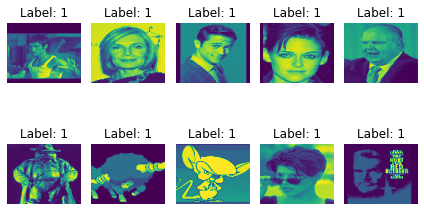

In [13]:
data = train_generator[0]  # 这实际上是调用__getitem__方法的另一种方式
images, labels = data
images_1, images_2 = images

print(images_1[0].shape)

for i in range(5):  # 显示前5张图片作为示例
    plt.subplot(2, 5, i+1)
    plt.imshow(images_1[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

# 显示Batch Images 2中的前几张图片
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(images_2[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    
    # 第一个卷积-池化块
    x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer=HeNormal())(input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    # 第二个卷积-池化块
    x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    # 第三个卷积-池化块
    x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)
    
    # 全连接层
    x = Flatten()(x)
    x = Dense(256, activation='relu', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(128, activation='relu', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    return Model(input, x)

In [15]:
# 计算欧几里得距离
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

In [16]:
# 定义孪生网络结构
# 从生成器中获取一个批次的数据
sample_batch = train_generator[0]
sample_images, _ = sample_batch
sample_image = sample_images[0][0]  # 获取第一个批次中的第一张图像

# 从样本图像中提取输入形状
input_shape = sample_image.shape
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance)([processed_a, processed_b])

model = Model([input_a, input_b], distance)


In [17]:
def contrastive_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # 转换y_true为float32类型
    margin = 1
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=contrastive_loss)

In [19]:
# 训练模型
model.fit(train_generator, epochs=5, steps_per_epoch=len(train_generator))

Epoch 1/5
1250/1250 [==============================] - 414s 330ms/step - loss: 164.5600
Epoch 2/5
1250/1250 [==============================] - 409s 327ms/step - loss: 3.0587
Epoch 3/5
1250/1250 [==============================] - 407s 325ms/step - loss: 0.0486
Epoch 4/5
1250/1250 [==============================] - 407s 325ms/step - loss: 0.0476
Epoch 5/5
1250/1250 [==============================] - 414s 331ms/step - loss: 0.0476


In [20]:
# distances = model.predict([np.repeat(test_images[0:1], len(train_images), axis=0), train_images])
# closest_index = np.argmin(distances)

In [21]:
test_pair=pd.read_csv("test_candidates.csv")
test_data = []
for i in range(len(test_pair)):
    left_path = test_pair.left[i] + '.jpg'
    for j in (test_pair.loc[i,"c0":"c19"]):
        temp = []
        right_path = j + '.jpg'
        temp.append(left_path)
        temp.append(right_path)
        temp.append(0)
        test_data.append(temp)

In [22]:
test_data[0:40]

[['abm.jpg', 'kyr.jpg', 0],
 ['abm.jpg', 'qqo.jpg', 0],
 ['abm.jpg', 'xpv.jpg', 0],
 ['abm.jpg', 'tnd.jpg', 0],
 ['abm.jpg', 'xal.jpg', 0],
 ['abm.jpg', 'pvr.jpg', 0],
 ['abm.jpg', 'nsb.jpg', 0],
 ['abm.jpg', 'yzv.jpg', 0],
 ['abm.jpg', 'ahb.jpg', 0],
 ['abm.jpg', 'mlm.jpg', 0],
 ['abm.jpg', 'drb.jpg', 0],
 ['abm.jpg', 'vqu.jpg', 0],
 ['abm.jpg', 'vzr.jpg', 0],
 ['abm.jpg', 'kxe.jpg', 0],
 ['abm.jpg', 'mdq.jpg', 0],
 ['abm.jpg', 'oai.jpg', 0],
 ['abm.jpg', 'nmm.jpg', 0],
 ['abm.jpg', 'yzu.jpg', 0],
 ['abm.jpg', 'ihk.jpg', 0],
 ['abm.jpg', 'zwv.jpg', 0],
 ['aci.jpg', 'jzn.jpg', 0],
 ['aci.jpg', 'hxw.jpg', 0],
 ['aci.jpg', 'iaj.jpg', 0],
 ['aci.jpg', 'edq.jpg', 0],
 ['aci.jpg', 'huu.jpg', 0],
 ['aci.jpg', 'huk.jpg', 0],
 ['aci.jpg', 'owo.jpg', 0],
 ['aci.jpg', 'ntd.jpg', 0],
 ['aci.jpg', 'uhk.jpg', 0],
 ['aci.jpg', 'ojv.jpg', 0],
 ['aci.jpg', 'mhg.jpg', 0],
 ['aci.jpg', 'exb.jpg', 0],
 ['aci.jpg', 'pny.jpg', 0],
 ['aci.jpg', 'kbo.jpg', 0],
 ['aci.jpg', 'tdb.jpg', 0],
 ['aci.jpg', 'sok.jp

In [23]:
# 创建一个没有数据增强的ImageDataGenerator实例
test_datagen = ImageDataGenerator(rescale=1./255)

# 使用ProjectDataGenerator为测试数据创建数据生成器
test_root = 'test'  # 如果你的测试数据在不同的目录，请更改此路径
test_generator = ProjectDataGenerator(test_root, test_data, test_datagen, batch_size=32, shuffle=False)

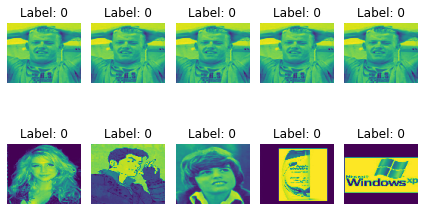

In [24]:
data = test_generator[0]  # 这实际上是调用__getitem__方法的另一种方式
images, labels = data
images_1, images_2 = images

for i in range(5):  # 显示前5张图片作为示例
    plt.subplot(2, 5, i+1)
    plt.imshow(images_1[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

# 显示Batch Images 2中的前几张图片
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(images_2[i].astype('uint8'))
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [25]:
predictions = model.predict(test_generator, steps=len(test_generator))

1250/1250 [==============================] - 124s 99ms/step


In [26]:
print(len(predictions))

40000


In [27]:
print(predictions[:200])

[[0.01745464]
 [0.01096785]
 [0.00436565]
 [0.01785473]
 [0.01692547]
 [0.01741272]
 [0.02416979]
 [0.01631056]
 [0.01438215]
 [0.01850895]
 [0.0170766 ]
 [0.01902147]
 [0.01716492]
 [0.00957525]
 [0.01094875]
 [0.00539749]
 [0.01672098]
 [0.01734372]
 [0.01850937]
 [0.00992345]
 [0.00424426]
 [0.01236376]
 [0.00756491]
 [0.01173136]
 [0.00479611]
 [0.00799396]
 [0.00980345]
 [0.00731847]
 [0.00969287]
 [0.00895166]
 [0.02215667]
 [0.00843061]
 [0.00603915]
 [0.00926838]
 [0.00595335]
 [0.01534376]
 [0.01023782]
 [0.01076846]
 [0.01114081]
 [0.00910379]
 [0.01038909]
 [0.01503772]
 [0.01234163]
 [0.01505183]
 [0.01631731]
 [0.00531543]
 [0.0069583 ]
 [0.00728252]
 [0.01433459]
 [0.00830612]
 [0.00907391]
 [0.01241053]
 [0.00691905]
 [0.02264023]
 [0.00952251]
 [0.01201638]
 [0.00793976]
 [0.00637314]
 [0.00769804]
 [0.01419626]
 [0.00790634]
 [0.00433552]
 [0.00969514]
 [0.00497881]
 [0.01016663]
 [0.01482431]
 [0.01728965]
 [0.01480633]
 [0.01354172]
 [0.00910993]
 [0.00950713]
 [0.01